## Imports

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
import math
from functools import partial
import torch
import torch.nn as nn
from timm.models.vision_transformer import PatchEmbed, Block
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from model_scripts.pos_embed import *
from model_scripts.train_mae import *
from model_scripts.MaskedAutoencoderViT import *
from model_scripts.MaskedAutoencoderViT_7ts import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from evaluation_scripts.patch_evaluation_helper import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import datetime
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

/home/k64835/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/k64835/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/k64835/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset prep: B10

In [4]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers, acquisition_dates, patch_tensor, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cube3('train', 'rgb')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cube3('eval', 'rgb')
patch_tensor.shape, patch_tensor_eval.shape

(torch.Size([2425, 3, 3, 64, 64]), torch.Size([48, 3, 3, 64, 64]))

In [5]:
timestamps = process_timestamps(field_numbers, acquisition_dates)
eval_timestamps = process_timestamps(field_numbers_eval, acquisition_dates_eval)
len(timestamps)

2425

In [6]:
train_tensor, test_tensor, train_field_numbers, test_field_numbers, timestamps_train, timestamps_test = train_test_split(
    patch_tensor, field_numbers, timestamps, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader_mae(train_tensor, train_field_numbers, timestamps_train, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader_mae(test_tensor, test_field_numbers, timestamps_test, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader_mae(patch_tensor_eval, field_numbers_eval, eval_timestamps, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)   # (N, T, C, H, W) -> (N, C, T, H, W)


In [7]:
for batch_inputs, batch_field_numbers, timestamps in dataloader_train:
    print("Batch Inputs Shape:", batch_inputs.shape)  
    # print("Batch Field Numbers:", batch_field_numbers)
    # print("Dates:", timestamps.shape)
    break 

Batch Inputs Shape: torch.Size([64, 3, 3, 64, 64])


## MAE Script -------> Runnnnnnnn

In [8]:
device = 'cuda'
epochs = 50
lr = 0.001
momentum=0.9
latent_dim=32
channels = 3
time_steps = 3
optimizer = 'Adam'
patch_size = config.subpatch_size
masking_ratio = 0.75
patch_size

4

In [9]:
model = MaskedAutoencoderViT(
        # img_size=64,
        patch_size=patch_size, embed_dim=768, depth=6, num_heads=6,
        decoder_embed_dim=512, decoder_depth=2, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
model.to(device)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(4, 4), stride=(4, 4))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
      (drop_path2): Identi

In [10]:
trained_model, train_losses, test_losses = train_model_mae(model, dataloader_train, dataloader_test, epochs=epochs, masking_ratio=masking_ratio, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.

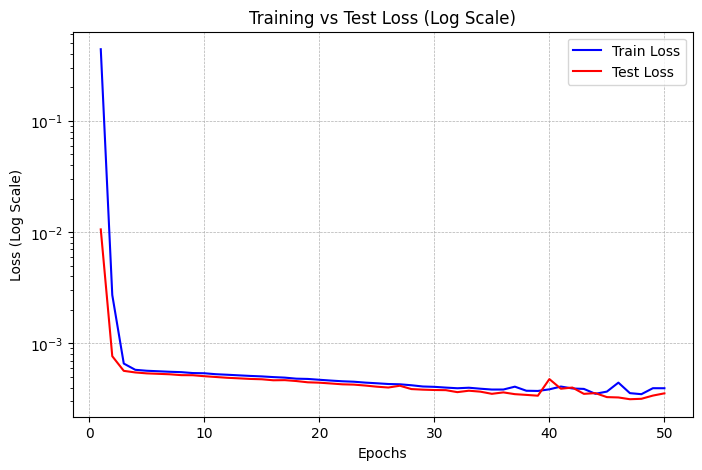

In [17]:
plot_loss_log_scale(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [18]:
train_features, train_fno = extract_latent_features_mae(trained_model, dataloader_train, device)
test_features, test_fno = extract_latent_features_mae(trained_model, dataloader_test, device)
eval_features, eval_fno = extract_latent_features_mae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_fno + test_fno

target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.Size([64, 256, 48])
target1 torch.

K-means on extracted features

In [21]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=105)

train_patch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_patch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
eval_patch_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int32)

In [23]:
acc, precision, recall, f1, f2 = get_clustering_accuracy(field_numbers_eval, eval_patch_predictions, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1)
print("F2-score",f2)

Accuracy: 0.5409836065573771
Precision: [0.         0.55932203]
Recall: [0.         0.94285714]
F1-score: [       nan 0.70212766]
F2-score 0.8291457286432161


/home/k64835/Master-Thesis-SITS/Evaluation/evaluation_scripts/patch_evaluation_helper.py:109: RuntimeWarning: invalid value encountered in divide
  f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)


target1 torch.Size([64, 256, 48])
torch.Size([64, 256, 48])
4
16 16
torch.Size([64, 256, 48])
4
16 16
torch.Size([64, 256, 48])
4
16 16


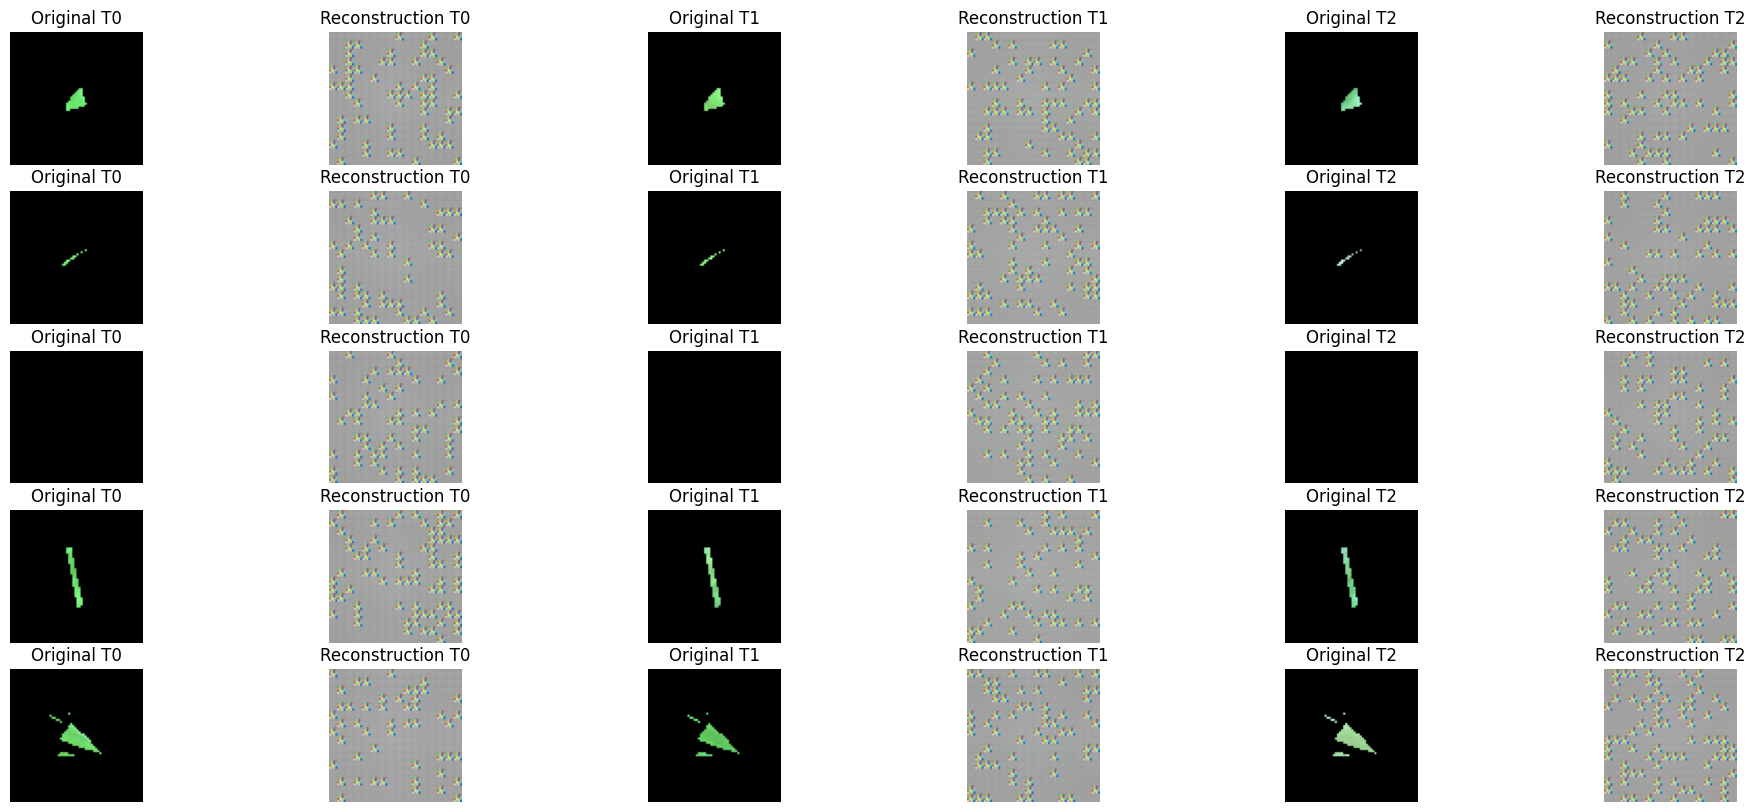

In [24]:
visualize_temporal_reconstructions(trained_model, dataloader_train, device, num_images=5, T=3)

## 7 Timesteps

In [ ]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers, acquisition_dates, patch_tensor, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'rgb')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'rgb')
patch_tensor.shape, patch_tensor_eval.shape

In [ ]:
timestamps = process_timestamps7(field_numbers, acquisition_dates)
eval_timestamps = process_timestamps7(field_numbers_eval, acquisition_dates_eval)
len(timestamps)

In [ ]:
train_tensor, test_tensor, train_field_numbers, test_field_numbers, timestamps_train, timestamps_test = train_test_split(
    patch_tensor, field_numbers, timestamps, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader_mae(train_tensor, train_field_numbers, timestamps_train, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader_mae(test_tensor, test_field_numbers, timestamps_test, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader_mae(patch_tensor_eval, field_numbers_eval, eval_timestamps, batch_size=config.ae_batch_size, shuffle=False)

In [ ]:
for batch_inputs, batch_field_numbers, timestamps in dataloader_train:
    print("Batch Inputs Shape:", batch_inputs.shape)  
    # print("Batch Field Numbers:", batch_field_numbers)
    print("Dates:", timestamps.shape)
    break 

In [ ]:
device = 'cuda'
epochs = 50
lr = 0.001
momentum=0.9
latent_dim=32
channels = 3
time_steps = 3
optimizer = 'Adam'
patch_size = config.subpatch_size
masking_ratio = 0.75
patch_size

In [ ]:
model = MaskedAutoencoderViT_7ts(
        # img_size=64,
        patch_size=patch_size, embed_dim=768, depth=4, num_heads=6,
        decoder_embed_dim=512, decoder_depth=2, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
model.to(device)

In [ ]:
trained_model, train_losses, test_losses = train_model_mae(model, dataloader_train, dataloader_test, epochs=epochs, masking_ratio=masking_ratio, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

In [ ]:
plot_loss_log_scale(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [ ]:
train_features, train_fno = extract_latent_features_mae(trained_model, dataloader_train, device)
test_features, test_fno = extract_latent_features_mae(trained_model, dataloader_test, device)
eval_features, eval_fno = extract_latent_features_mae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_fno + test_fno

K-means on extracted features

In [ ]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=103)

train_patch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_patch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

In [ ]:
eval_patch_predictions

In [ ]:
acc, precision, recall, f1, f2 = get_clustering_accuracy(field_numbers_eval, eval_patch_predictions, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1)
print("F2-score:",f2)

In [ ]:
visualize_reconstructions(trained_model, dataloader_train, device, num_images=5)

## MAE functions --- tweeked for our usecase :) --- remove later

### Patchify function

In [ ]:
import torch

def patchify(self, images, patch_size=4):
    """ images: (N,C,H,W)
        patches(x): (N, L, patch_size ** 2 * C) 
        valid_patch_mask: (N, L)
    """

    N, C, H, W = images.shape
    p = patch_size
    # p = self.patch_embed.patch_size[0]

    assert H % p == 0 and W % p == 0, "Image dimensions must be divisible by patch_size"
    
    h = w = H // p
    print(h,w)
    x = images.reshape(shape = (N, C, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(N, h * w, p**2 * C))

    # Create valid patch mask (1 for non-zero patches, 0 for black patches)
    # A black patch is a patch with all zeros, so check if the sum of the patch is zero
    valid_patch_mask = (x.sum(dim=-1) != 0).float()  # Shape: (B, num_patches)

    return x , valid_patch_mask


In [ ]:
# visualize_temporal_stack_rgb(images_visualisation_train[0],acquisition_dates_train[field_numbers_train[0]])

In [ ]:
patch_tensor[:,0,:,:,:].shape

In [ ]:
patchified, valid_patch_mask = patchify(0, patch_tensor[:,0,:,:,:])

In [ ]:
patchified.shape

In [ ]:
valid_patch_mask.shape

### Un-patchify function

In [ ]:
def unpatchify(x):
    """
    x: (N, L, patch_size**2 * C)
    imgs: (N, C, H, W)
    Dont need to handle valid_patch_mask because we wont be sending invalid patches to the encoder and decoder.. 
    So at the end we only have valid patches to unpatchify..
    """
    print(x.shape)
    N, L, O = x.shape
    # p = patch_size
    p = 4
    print(p)
    h = w = int(x.shape[1]**.5)
    print(h,w)
    assert h * w == x.shape[1]

    C = O // p**2
    x = x.reshape(N, h, w, p, p, C)
    x = torch.einsum('nhwpqc->nchpwq', x)

    images = x.reshape(N, C, h*p, h*p)
    return images

In [ ]:
unpatchified_images = unpatchify(patchified)
unpatchified_images.shape

In [ ]:
unpatchified_images_r = unpatchified_images.permute(0,2,3,1)
unpatchified_images_s = normalize_for_display(unpatchified_images_r)
plt.imshow(unpatchified_images_s[0])

### Random Masking 

In [ ]:
def random_masking_with_max(self, x, mask_ratio, valid_patch_mask, mask=None):
    """ Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffiling is done by argsort random noise.
        x: [N,L,D], sequence
        Here, we completely discard the black patches, and use only valid patches as input for- masking and shuffing ..
    """

    N, L, D = x.shape  # Batch, length, p^2 * C
    # len_keep = int(L * (1 - mask_ratio))

    valid_patch_mask = valid_patch_mask.bool()
    print(x.shape, valid_patch_mask.shape)          # [2425, 256, 48], [2425, 256]

    # Remove samples with no valid patches
    valid_samples = valid_patch_mask.sum(dim=1) > 0  
    x = x[valid_samples]
    valid_patch_mask = valid_patch_mask[valid_samples]
    print(x.shape, valid_patch_mask.shape)          # [2345, 256, 48], [2345, 256]

    x_valid_list = []

    for i in range(x.shape[0]):
        valid_patches = x[i][valid_patch_mask[i]]
        x_valid_list.append(valid_patches)

    # max_valid_patches = max([valid_patch_mask[i].sum().item() for i in range(x.shape[0])])
    max_valid_patches = 200      # take as hyperparam later
    print(max_valid_patches)

    # Pad each sample's valid patches to the max number of valid patches
    padded_x_valid_list = []
    for valid_patches in x_valid_list:

        avg_value = valid_patches.mean(dim=0)       # Average along the patch dimension (dim=0)
        avg_value_scalar = avg_value.mean().item()  
        padding_size = max_valid_patches - valid_patches.shape[0]
        # padded_valid_patches = F.pad(valid_patches, (0, 0, 0, padding_size), value=avg_value_scalar)
        padded_valid_patches = F.pad(valid_patches, (0, 0, 0, padding_size), value=0)
        padded_x_valid_list.append(padded_valid_patches)

    padded_x_valid = torch.stack(padded_x_valid_list)
    print(padded_x_valid.shape)      # [2325, max_valid_patches, 48]

    # Update variables
    N = padded_x_valid.shape[0]  
    L = max_valid_patches
    len_keep = int(L * (1 - mask_ratio))
    # noise = torch.randn(N, max_valid_patches, device=padded_x_valid.device)  # Use updated N
    noise = torch.randn(N, L, device=padded_x_valid.device)  # Noise [0,1]

    # if self.same_mask:
    if True:

        while L % 4 != 0:
            L += 1

        L2 = L // 4             # 4 components (Original code had 3 components, but we keep 4)
        assert 4 * L2 == L
        noise = torch.randn(N, L2, device=padded_x_valid.device)  # Noise [0,1] for L2 tokens
        ids_shuffle = torch.argsort(noise, dim=1)    # Shuffling
        ids_shuffle = [ids_shuffle + i * L2 for i in range(3)]

        ids_shuffle_keep = [z[: ,:int(L2 * (1 - mask_ratio))] for z in ids_shuffle]     # To Keep
        ids_shuffle_disc = [z[: ,int(L2 * (1 - mask_ratio)):] for z in ids_shuffle]     # To Mask
        ids_shuffle = []
        for z in ids_shuffle_keep:
            ids_shuffle.append(z)
        for z in ids_shuffle_disc:
            ids_shuffle.append(z)
        ids_shuffle = torch.cat(ids_shuffle, dim=1)

    else:
        if mask is None:
            ids_shuffle = torch.argsort(noise, dim=1)   # if no mask, noise small=keep, noise large=remove
        else:
            ids_shuffle = mask
    
    ids_restore = torch.argsort(ids_shuffle, dim=1) # For restoring the unshuffled version

    ids_keep = ids_shuffle[:,:len_keep]             # Keep 1st subset
    x_masked = torch.gather(padded_x_valid, dim=1, index=ids_keep.unsqueeze(-1).repeat(1,1,D))

    # Binary mask: 0 = keep, 1 = remove
    mask = torch.ones([N, L], device=padded_x_valid.device)
    mask[:, :len_keep] = 0
    mask = torch.gather(mask, dim=1, index=ids_restore)      # Unshuffle to get the binary mask

    return x_masked, mask, ids_restore

In [ ]:
def random_masking(self, x, mask_ratio, valid_patch_mask, mask=None):
    """ Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffiling is done by argsort random noise.
        x: [N,L,D], sequence
        Here, we completely discard the black patches, and use only valid patches as input for- masking and shuffing ..
    """

    N, L, D = x.shape  # Batch, length, p^2 * C
    len_keep = int(L * (1 - mask_ratio))

    valid_patch_mask = valid_patch_mask.bool()
    print(x.shape, valid_patch_mask.shape)          # [2425, 256, 48], [2425, 256]

    # Remove samples with no valid patches
    valid_samples = valid_patch_mask.sum(dim=1) > 0  
    x = x[valid_samples]
    valid_patch_mask = valid_patch_mask[valid_samples]
    print(x.shape, valid_patch_mask.shape)          # [2345, 256, 48], [2345, 256]

    # Update variables
    N = x.shape[0]  
    noise = torch.randn(N, L, device=x.device)  # Noise [0,1]

    # if self.same_mask:
    if True:

        while L % 4 != 0:
            L += 1

        L2 = L // 4             # 4 components (Original code had 3 components, but we keep 4)
        assert 4 * L2 == L
        noise = torch.randn(N, L2, device=x.device)  # Noise [0,1] for L2 tokens
        ids_shuffle = torch.argsort(noise, dim=1)    # Shuffling
        ids_shuffle = [ids_shuffle + i * L2 for i in range(3)]

        ids_shuffle_keep = [z[: ,:int(L2 * (1 - mask_ratio))] for z in ids_shuffle]     # To Keep
        ids_shuffle_disc = [z[: ,int(L2 * (1 - mask_ratio)):] for z in ids_shuffle]     # To Mask
        ids_shuffle = []
        for z in ids_shuffle_keep:
            ids_shuffle.append(z)
        for z in ids_shuffle_disc:
            ids_shuffle.append(z)
        ids_shuffle = torch.cat(ids_shuffle, dim=1)

    else:
        if mask is None:
            ids_shuffle = torch.argsort(noise, dim=1)   # if no mask, noise small=keep, noise large=remove
        else:
            ids_shuffle = mask
    
    ids_restore = torch.argsort(ids_shuffle, dim=1) # For restoring the unshuffled version

    ids_keep = ids_shuffle[:,:len_keep]             # Keep 1st subset
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1,1,D))

    # Binary mask: 0 = keep, 1 = remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    mask = torch.gather(mask, dim=1, index=ids_restore)      # Unshuffle to get the binary mask

    return x_masked, mask, ids_restore

In [ ]:
x_masked, mask, ids_restore = random_masking(0, patchified, 0.75, valid_patch_mask)

In [ ]:
x_masked.shape

In [ ]:
mask.shape

In [ ]:
ids_restore.shape

In [ ]:
valid_patch_mask.shape

### Encoder

In [ ]:
acquisition_dates_eval['1168663.0_1176271.0']

#### Correct Acquisition Dates Format

In [ ]:
timestamps_train = process_timestamps(field_numbers, acquisition_dates)
timestamps_train.shape

In [ ]:
acquisition_dates['1167134.0']

In [ ]:
field_numbers[0]

#### Encoder Forward function

In [ ]:
def forward_encoder(self, x, timestamps, mask_ratio, mask=None):
    
    
    # Patch Embeddings for all 3 temporal images
    x1 = self.patch_embed(x[:, 0])
    x2 = self.patch_embed(x[:, 1])
    x3 = self.patch_embed(x[:, 2])
    x = torch.cat([x1, x2, x3], dim=1)
    
    # Temporal Embeddings
    print(timestamps.shape, x.shape)
    ts_embed = torch.cat([get_1d_sincos_pos_embed_from_grid_torch(128, timestamps.reshape(-1, 3)[:, 0].float()),
                get_1d_sincos_pos_embed_from_grid_torch(128, timestamps.reshape(-1, 3)[:, 1].float()),
                get_1d_sincos_pos_embed_from_grid_torch(128, timestamps.reshape(-1, 3)[:, 2].float())], dim=1).float()
    
    # ts_embed = torch.cat([
    #     get_1d_sincos_pos_embed_from_grid_torch(128, timestamps[:, :, 0].reshape(-1, 1)),  # Year
    #     get_1d_sincos_pos_embed_from_grid_torch(128, timestamps[:, :, 1].reshape(-1, 1)),  # Month
    #     get_1d_sincos_pos_embed_from_grid_torch(128, timestamps[:, :, 2].reshape(-1, 1))   # Day
    # ], dim=1).float()
    
    print(ts_embed, ts_embed.shape)
    
    ts_embed = ts_embed.reshape(-1, 3, ts_embed.shape[-1]).unsqueeze(2)
    print(ts_embed.shape)
    ts_embed = ts_embed.expand(-1, -1, x.shape[1] // 3, -1).reshape(x.shape[0], -1, ts_embed.shape[-1])
    print(ts_embed.shape)

    # Add positional embedding without cls token
    x = x + torch.cat([self.pos_embed[:, 1:, :].repeat(ts_embed.shape[0], 3, 1), ts_embed], dim=-1)

    # Masking: length -> length * mask_ratio
    x, mask, ids_restore = self.random_masking(x, mask_ratio, mask=mask)

    # Append cls token
    cls_token = self.cls_token #+ self.pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)

    # Transformer blocks
    for blk in self.blocks:
        x = blk(x)
    x = self.norm(x)

    return x, mask, ids_restore


### Decoder

In [ ]:
def forward_decoder(self, x, timestamps, ids_restore):
        
        # Decoder Embeddings for tokens
        x = self.decoder_embed(x)

        # Append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)                                       # No cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # Unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)                                                 # Append cls token


        ts_embed = torch.cat([get_1d_sincos_pos_embed_from_grid_torch(64, timestamps.reshape(-1, 3)[:, 0].float()),
                   get_1d_sincos_pos_embed_from_grid_torch(64, timestamps.reshape(-1, 3)[:, 1].float()),
                   get_1d_sincos_pos_embed_from_grid_torch(64, timestamps.reshape(-1, 3)[:, 2].float())], dim=1).float()
        
        ts_embed = ts_embed.reshape(-1, 3, ts_embed.shape[-1]).unsqueeze(2)
        ts_embed = ts_embed.expand(-1, -1, x.shape[1] // 3, -1).reshape(x.shape[0], -1, ts_embed.shape[-1])

        ts_embed = torch.cat([torch.zeros((ts_embed.shape[0], 1, ts_embed.shape[2]), device=ts_embed.device), ts_embed], dim=1)

        # Add positional embedding
        x = x + torch.cat(
            [torch.cat([self.decoder_pos_embed[:, :1, :], self.decoder_pos_embed[:, 1:, :].repeat(1, 3, 1)], dim=1).expand(ts_embed.shape[0], -1, -1),
             ts_embed], dim=-1)

        # Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # Predictor projection
        x = self.decoder_pred(x)

        # Remove cls token
        x = x[:, 1:, :]

        return x

In [ ]:
def forward_loss(self, images, pred, mask):
        """
        images: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove
        """
        target1 = self.patchify(images[:, 0])
        target2 = self.patchify(images[:, 1])
        target3 = self.patchify(images[:, 2])
        target = torch.cat([target1, target2, target3], dim=1)
        previous_target = target
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        # viz code
        '''
        m = torch.tensor([0.4182007312774658, 0.4214799106121063, 0.3991275727748871]).reshape(1, 3, 1, 1)
        std = torch.tensor([0.28774282336235046, 0.27541765570640564, 0.2764017581939697]).reshape(1, 3, 1, 1)
        
        image = (pred * (var + 1.e-6)**.5) + mean
        bs = image.shape[0]
        image = image.reshape(bs, 3, -1, image.shape[-1])[0]
        image = self.unpatchify(image).detach().cpu()
        image = image * std + m

        save_image(image, f'viz1/viz_{self.counter}.png')
        masked_image = self.patchify(image)
        masked_image.reshape(-1, 768)[mask[0].bool()] = 0.5
        masked_image = self.unpatchify(masked_image.reshape(3, -1 ,768))
        save_image(masked_image, f'viz1/viz_mask_{self.counter}.png')

        previous_target = previous_target.reshape(bs, 3, -1, previous_target.shape[-1])[0]
        previous_target = self.unpatchify(previous_target).detach().cpu()
        previous_target = previous_target * std + m
        save_image(previous_target, f'viz1/target_{self.counter}.png')

        masked_image = self.patchify(previous_target)
        masked_image.reshape(-1, 768)[mask[0].bool()] = 0.5
        masked_image = self.unpatchify(masked_image.reshape(3, -1 ,768))
        save_image(masked_image, f'viz1/viz_target_mask_{self.counter}.png')
        # print(image.shape)
        # assert False
        self.counter += 1
        '''

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)                 # [N, L], mean loss per patch
        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

def forward(self, imgs, timestamps, mask_ratio=0.75, mask=None):
    latent, mask, ids_restore = self.forward_encoder(imgs, timestamps, mask_ratio, mask=mask)
    pred = self.forward_decoder(latent, timestamps, ids_restore)  # [N, L, p*p*3]
    loss = self.forward_loss(imgs, pred, mask)
    return loss, pred, mask

### All Functions Together in a Class

### --old-- POS encoding

In [ ]:
# Example usage
N = 4  # Batch size
T = 7  # Number of temporal images (7 acquisition dates)
C = 10  # Number of channels
H = 64  # Image height
W = 64  # Image width

images = torch.randn(N, T, C, H, W)  # Example batch of satellite images
temporal_indices = torch.arange(T).unsqueeze(0).expand(N, -1)  # Example temporal indices

# Create model
model = MAEViT(embed_dim=256, num_heads=8, ff_dim=1024, num_layers=6, num_patches=256, patch_size=16, img_size=64, num_channels=10)

# Forward pass
reconstructed_images = model(images, temporal_indices)

print(f"Reconstructed Images shape: {reconstructed_images.shape}")